In [1]:
# Tyler Edwards
# Professional League of Legends Champion Network

# Takes data from League of Legends pro matches and creates a network of champions played linked together by teams they were on.

import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import pandas as pd
import os


In [2]:
# Data is from Oracle's Exlixir Google drive.
file = "loltrim.csv"
df = pd.read_csv(file)

# *** Change "scope" to the league, team, or patch you want to filter the data for, and uncomment the appropriate filter below.
# Commenting out 
scope = 'T1' # Region/Team/patch/etc.

# df = df[df['league'] == scope]
df = df[df['teamname'] == scope]
# df = df[df['patch'] == scope]

# Creating an ID for each game + which team they were on that game
df["gameside"] = df["gameid"] + "|" + df["side"]
print(df.shape)
df.head(10)

(215, 25)


,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,teamname,teamid,champion,ban1,ban2,ban3,ban4,ban5,gamelength,gameside
270,ESPORTSTMNT04_2660040,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:00,1,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Gnar,Maokai,Ryze,Ashe,Wukong,Kassadin,2162,ESPORTSTMNT04_2660040|Blue
271,ESPORTSTMNT04_2660040,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:00,1,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Vi,Maokai,Ryze,Ashe,Wukong,Kassadin,2162,ESPORTSTMNT04_2660040|Blue
272,ESPORTSTMNT04_2660040,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:00,1,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Azir,Maokai,Ryze,Ashe,Wukong,Kassadin,2162,ESPORTSTMNT04_2660040|Blue
273,ESPORTSTMNT04_2660040,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:00,1,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Lucian,Maokai,Ryze,Ashe,Wukong,Kassadin,2162,ESPORTSTMNT04_2660040|Blue
274,ESPORTSTMNT04_2660040,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:00,1,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Nami,Maokai,Ryze,Ashe,Wukong,Kassadin,2162,ESPORTSTMNT04_2660040|Blue
290,ESPORTSTMNT04_2661049,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:59,2,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Fiora,Maokai,Elise,Ryze,Kassadin,K'Sante,1939,ESPORTSTMNT04_2661049|Blue
291,ESPORTSTMNT04_2661049,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:59,2,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Wukong,Maokai,Elise,Ryze,Kassadin,K'Sante,1939,ESPORTSTMNT04_2661049|Blue
292,ESPORTSTMNT04_2661049,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:59,2,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Lissandra,Maokai,Elise,Ryze,Kassadin,K'Sante,1939,ESPORTSTMNT04_2661049|Blue
293,ESPORTSTMNT04_2661049,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:59,2,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Lucian,Maokai,Elise,Ryze,Kassadin,K'Sante,1939,ESPORTSTMNT04_2661049|Blue
294,ESPORTSTMNT04_2661049,complete,NaN,LCK,2023,Spring,0,1/18/2023 11:59,2,13.01,...,T1,oe:team:ce499dea30cfce118f4fe85da0227e8,Nami,Maokai,Elise,Ryze,Kassadin,K'Sante,1939,ESPORTSTMNT04_2661049|Blue


In [3]:
# Dataframe with only relevant columns
df2 = df[['champion', 'position']]

# Dataframe to assign a role to each node (Champion)
# Some champions are played in multiple roles but we're just taking the one they were played in the most.
df2count = df.groupby(["champion", "position"]).size().reset_index(name="count")
df2count = df2count.sort_values(by=['count'], ascending=False)
df2count = df2count.drop_duplicates(subset="champion", keep='first')

df2 = df2.drop_duplicates(subset='champion', keep="first")
print(df2.shape)

# Dictionary of Champions and their roles
roles = dict(zip(df2count['champion'], df2count['position']))

# Changing roles to colors for the network node colors.
for key, val in roles.items():
    if val == 'top':
        roles[key] = 'deepskyblue'
    elif val == 'jng':
        roles[key] = 'lime'
    elif val == 'mid':
        roles[key] = 'magenta'
    elif val == 'bot':
        roles[key] = 'orange'
    elif val == 'sup':
        roles[key] = 'yellow'


(60, 2)


In [4]:
# Dataframe for network
df3 = pd.DataFrame(columns = ["champion1", "champion2"])
   
# For each 'gameside' there is a row made for every combination of two champions on that team.
for i in df.gameside.unique():
    team_df = df.loc[(df['gameside'] == i)]
    team_comp = team_df["champion"]
    combinations = [(a, b) for idx, a in enumerate(team_comp) for b in team_comp[idx + 1:]]
    for i in combinations:
        new_row = {"champion1": i[0], "champion2": i[1]}
        df3.loc[len(df3)] = new_row
        
print(df3.shape)
df3.head(10)


(430, 2)


,champion1,champion2
0,Gnar,Vi
1,Gnar,Azir
2,Gnar,Lucian
3,Gnar,Nami
4,Vi,Azir
5,Vi,Lucian
6,Vi,Nami
7,Azir,Lucian
8,Azir,Nami
9,Lucian,Nami


In [5]:
# Creating network and graphs

G = nx.from_pandas_edgelist(df3, 'champion1', 'champion2', create_using=nx.Graph())
d = dict(G.degree)

0.17231638418079095
4


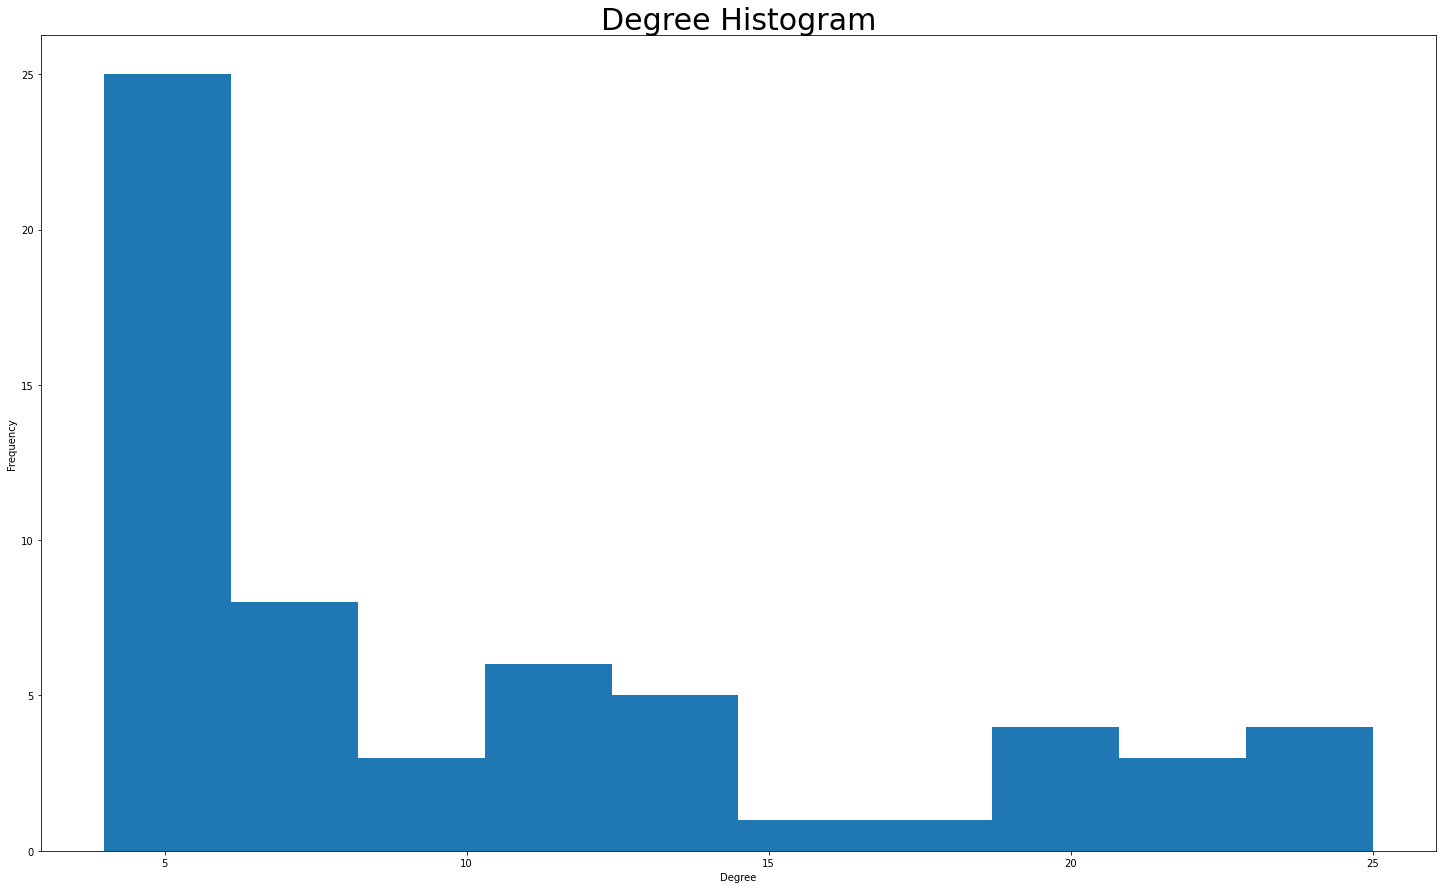

In [6]:
# Density, Connectivity, and Degree Histogram

print(nx.density(G))
print(nx.edge_connectivity(G))

degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(25, 15)) 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Histogram', fontsize=30)
plt.hist(degrees)
plt.show()

Text(0.5, 1.0, 'LoLPro Champion Network (T1)')

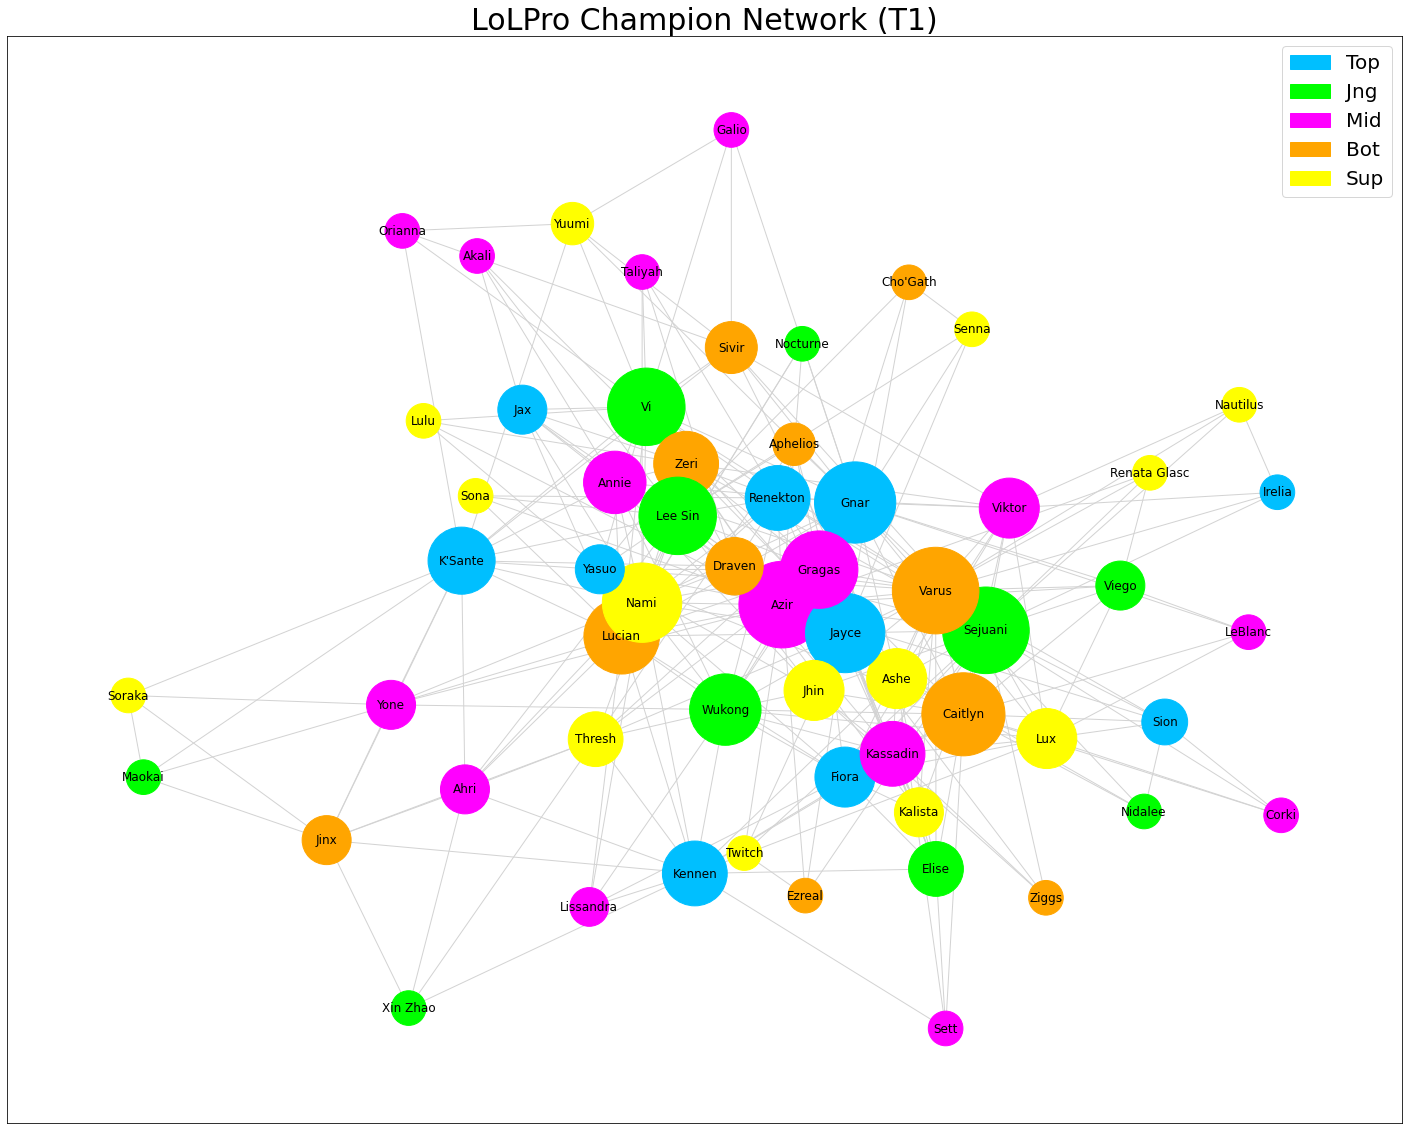

In [7]:
f = plt.figure(figsize=(25,20))
f.tight_layout()

color_map = [roles.get(node) for node in G.nodes()]

# change the scalar(x) in "v * x" to change the size of the nodes apprortiate to the size of the data
nx.draw_networkx(G, pos=nx.spring_layout(G, seed = 8), with_labels=True, node_size=[v * 300 for v in d.values()], node_color = color_map, edge_color = 'lightgrey')
# Change node size scalar if scope is smaller (team) or larger (region)

# Manually adding legend
patch1 = mpatches.Patch(color='deepskyblue', label='Top')
patch2 = mpatches.Patch(color='lime', label='Jng')
patch3 = mpatches.Patch(color='magenta', label='Mid')
patch4 = mpatches.Patch(color='orange', label='Bot')
patch5 = mpatches.Patch(color='yellow', label='Sup')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], fontsize="20")

# Change title if there's no scope
plt.title('LoLPro Champion Network (' + scope + ')', fontsize=30)
# plt.title('LoLPro Champion Network (LCS, LEC, LCK, LPL)', fontsize=30)


In [8]:
# Assigning portraits to each node
portraits = {}
for node in G.nodes():
    portraits[node] = 'LolPortraits/'+(node + "Square").replace(" ", "_")+".png"
    
for i in G.nodes():
    img = mpimg.imread(portraits[i])
    G.add_node(i,image= img)

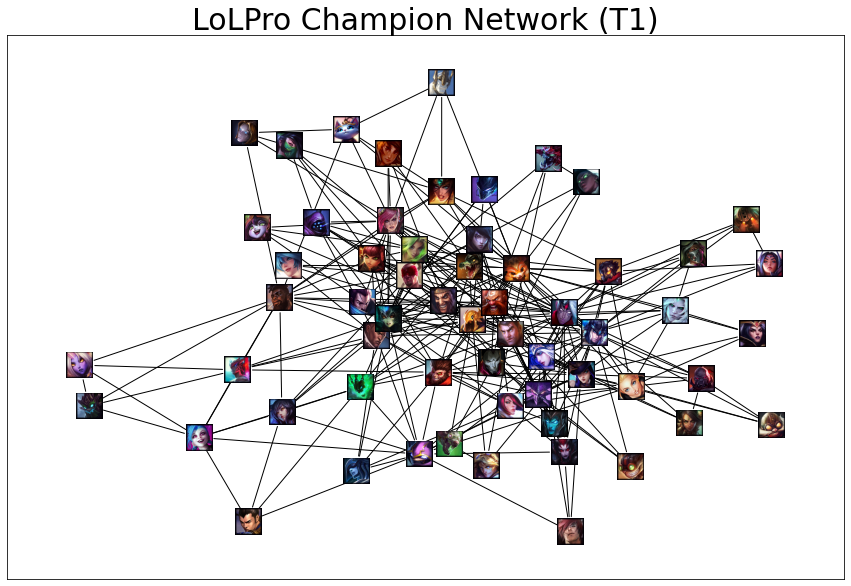

In [9]:
# Places images on node locations in graph.

fig=plt.figure(figsize=(15,10))
ax=plt.subplot(111)

# Change title if there's no scope
plt.title('LoLPro Champion Network (' + scope + ')', fontsize=30)
# plt.title('LoLPro Champion Network (LCS, LEC, LCK, LPL)', fontsize=30)

pos = nx.spring_layout(G, seed = 8)
nx.draw_networkx_edges(
    G,
    pos=pos,
    ax = ax,
    arrows=True,
    arrowstyle="-",
    min_source_margin=15,
    min_target_margin=15,
)
tr_figure = ax.transData.transform
tr_axes = fig.transFigure.inverted().transform
icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.017
icon_center = icon_size / 2.0
for n in G.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(G.nodes[n]["image"])
    a.axis("off")
    
plt.show()


In [10]:
# Centrality
c_degree = pd.DataFrame(list(nx.degree_centrality(G).items()), columns = ['Champion', 'Degree_Centrality'])
c_eigen = pd.DataFrame(list(nx.eigenvector_centrality(G).items()), columns = ['Champion', 'Eigen_Centrality'])
c_between = pd.DataFrame(list(nx.betweenness_centrality(G).items()), columns = ['Champion', 'Betweenness_Centrality'])
PgRank = pd.DataFrame(list(nx.pagerank(G, alpha = 0.9).items()), columns = ['Champion', 'PageRank'])


C = c_degree.merge(c_eigen, how='inner', on='Champion')
C = C.merge(c_between, how='inner', on='Champion')
C = C.merge(PgRank, how='inner', on='Champion')
C = C.sort_values(by=['Degree_Centrality'], ascending=False)
C.head(15)

# Open in Excel to easily sort and look at top champions easier
# C.to_csv('centrality.csv', index=False)


,Champion,Degree_Centrality,Eigen_Centrality,Betweenness_Centrality,PageRank
2,Azir,0.423729,0.252548,0.102088,0.039209
16,Varus,0.423729,0.260884,0.087870,0.038463
14,Sejuani,0.423729,0.226999,0.087436,0.039398
21,Caitlyn,0.389831,0.237587,0.067169,0.035551
0,Gnar,0.372881,0.231105,0.076525,0.034147
4,Nami,0.355932,0.221100,0.048276,0.032384
22,Jayce,0.355932,0.219759,0.065586,0.032918
1,Vi,0.338983,0.200335,0.062540,0.031555
44,Lee Sin,0.338983,0.194642,0.061669,0.031441
37,Gragas,0.338983,0.230181,0.040478,0.030714


In [11]:
print(nx.prominent_group(G,5))
# Same as the nodes with the top 5 betweeness centrality.

(0.43, ['Azir', 'Sejuani', 'Varus', 'Gnar', 'Lee Sin'])
